## import

In [1]:
import tensorflow.examples.tutorials.mnist.input_data as input_data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
"""
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
"""

"\n%matplotlib inline\nplt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots\nplt.rcParams['image.interpolation'] = 'nearest'\nplt.rcParams['image.cmap'] = 'gray'\n"

## 1 - Datasets

In [3]:
mnist = input_data.read_data_sets("datasets/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting datasets/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting datasets/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting datasets/t10k-images-idx3-ubyte.gz
Extracting datasets/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
train_x_orig,train_y_orig,test_x_orig,test_y_orig=mnist.train.images,mnist.train.labels,mnist.test.images,mnist.test.labels

y= 7


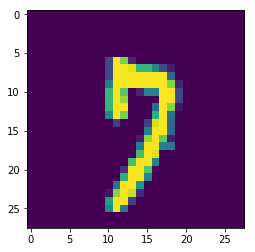

In [5]:
index = 25
plt.imshow(train_x_orig[index].reshape(28,28))
print("y= "+str(int(np.squeeze(np.dot(train_y_orig[index].reshape(1,-1),np.array([0,1,2,3,4,5,6,7,8,9]).reshape(-1,1))))))

In [6]:
train_x=train_x_orig[0:2000].T
train_y=train_y_orig[0:2000].T
test_x=test_x_orig.T
test_y=test_y_orig.T
print("The shape of train_x is ("+ str(train_x.shape[0])+', '+str(train_x.shape[1])+')')
print("The shape of train_y is ("+ str(train_y.shape[0])+', '+str(train_y.shape[1])+')')
print("The shape of test_x is ("+ str(test_x.shape[0])+', '+str(test_x.shape[1])+')')
print("The shape of test_y is ("+ str(test_y.shape[0])+', '+str(test_y.shape[1])+')')

The shape of train_x is (784, 2000)
The shape of train_y is (10, 2000)
The shape of test_x is (784, 10000)
The shape of test_y is (10, 10000)


## 2 - L-layers init paras

In [7]:
def init_paras(X,Y,lims):
    np.random.seed(0)
    paras={}
    L=len(lims)
    
    paras["W1"]=np.random.randn(lims[0],X.shape[0])*0.01
    paras["b1"]=np.zeros((lims[0],1))
    for l in range(1,L):
        paras["W"+str(l+1)]=np.random.randn(lims[l],lims[l-1])*0.01
        paras["b"+str(l+1)]=np.zeros((lims[l],1))
    paras["W"+str(L+1)]=np.random.randn(Y.shape[0],lims[L-1])*0.01
    paras["b"+str(L+1)]=np.zeros((Y.shape[0],1))
    return paras

## 3 - L-layers forward propagate

In [8]:
def relu(Z):
    return np.maximum(0,Z)
def sigmoid(Z):
    return 1/(1+np.exp(-Z))
def linear_forward(A_prev,W,b,activation):
    Z=np.dot(W,A_prev)+b
    A=activation(Z)
    cache=(A_prev,W,b,Z)
    return A,cache

In [9]:
def forward_propagate(X,paras):
    L=len(paras)//2
    caches=[]
    A=X
    for l in range(1,L):
        A,cache=linear_forward(A,paras["W"+str(l)],paras["b"+str(l)],relu)
        caches.append(cache)
    AL,cache=linear_forward(A,paras["W"+str(L)],paras["b"+str(L)],sigmoid)
    caches.append(cache)
    return AL,caches

## 4 - Compute cost

In [10]:
def compute_cost(AL,Y):
    cost=np.sum(np.multiply(-np.log(AL),Y)+np.multiply(-np.log(1-AL),(1-Y)))/Y.shape[1]   
    return cost

## 5 - Backward propagate

In [11]:
def linear_back(dA,cache):
    A_prev,W,b,Z=cache
    m=dA.shape[1]
    dZ=relu_back(dA,Z)
    dW=np.dot(dZ,A_prev.T)/m
    dA_prev=np.dot(W.T,dZ)
    db=np.sum(dZ,axis = 1, keepdims = True)/m
    return dW,dA_prev,db
def relu_back(dA,Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [12]:
def backward_propagate(X,Y,caches,AL):
    grads={}
    L=len(caches)
    m=Y.shape[1]
    
    A_prev,W,b,Z=caches[L-1]
    grads["dW"+str(L)]=np.dot(AL-Y,A_prev.T)/m
    grads["db"+str(L)]=np.sum(AL-Y,axis = 1, keepdims = True)/m
    grads["dA"+str(L-1)]=np.dot(W.T,AL-Y)
    
    for l in reversed(range(L-1)):
        grads["dW"+str(l+1)],grads["dA"+str(l)],grads["db"+str(l+1)]=linear_back(grads["dA"+str(l+1)],caches[l])
    return grads

## 6 - Updata paras

In [13]:
def updata_paras(paras,grads,learning_rate=0.6):
    L=len(paras)//2
    for l in range(1,L+1):
        paras["W"+str(l)]-=learning_rate*grads["dW"+str(l)]
        paras["b"+str(l)]-=learning_rate*grads["db"+str(l)]
    return paras

In [17]:
def model(X, Y, layers_dims, learning_rate = 0.3, num_iterations = 3000, print_cost=True):
    costs = []
    paras=init_paras(train_x,train_y,layers_dims)
    for i in range(0, num_iterations):
        AL,caches=forward_propagate(train_x,paras)
        cost=compute_cost(AL,train_y)
        grads=backward_propagate(train_x,train_y,caches,AL)
        paras=updata_paras(paras,grads,learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return paras

In [18]:
def predict(X,Y,paras):
    AL,_=forward_propagate(X,paras)
    m = X.shape[1]

    p=AL.argmax(0)
    y=Y.argmax(0)
    
    num=0
    for i in range(len(p)):
        if p[i]==y[i]:
            num+=1
    print("Accuracy: "  + str(num/m))

Cost after iteration 0: 6.931426
Cost after iteration 100: 3.253433
Cost after iteration 200: 3.210701
Cost after iteration 300: 2.936799
Cost after iteration 400: 2.794458
Cost after iteration 500: 2.733623
Cost after iteration 600: 2.659134
Cost after iteration 700: 2.522992
Cost after iteration 800: 2.046296
Cost after iteration 900: 1.611268


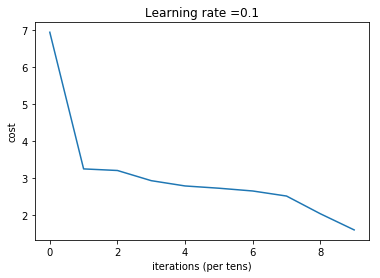

In [19]:
layers_dims=[8,7]
paras=model(train_x, train_y, layers_dims,learning_rate = 0.1,num_iterations = 1000)

In [20]:
pred_train = predict(train_x, train_y, paras)

Accuracy: 0.791


In [21]:
pred_test=predict(test_x,test_y,paras)

Accuracy: 0.7259
